# Imports

In [1]:
%load_ext autoreload

In [2]:
import numpy as np
from src import *

%autoreload 2

# Signal

In [3]:
# Signal width
N = 128

# Sparse signal parameters
sparse_range = (-6, 6)
density = 0.005

# Smooth signal parameters
smooth_amplitude = 2
sigmas_range = (2e-2, 2e-1)
nb_gaussian = int(0.5 * N)

# Seed
seed = 42

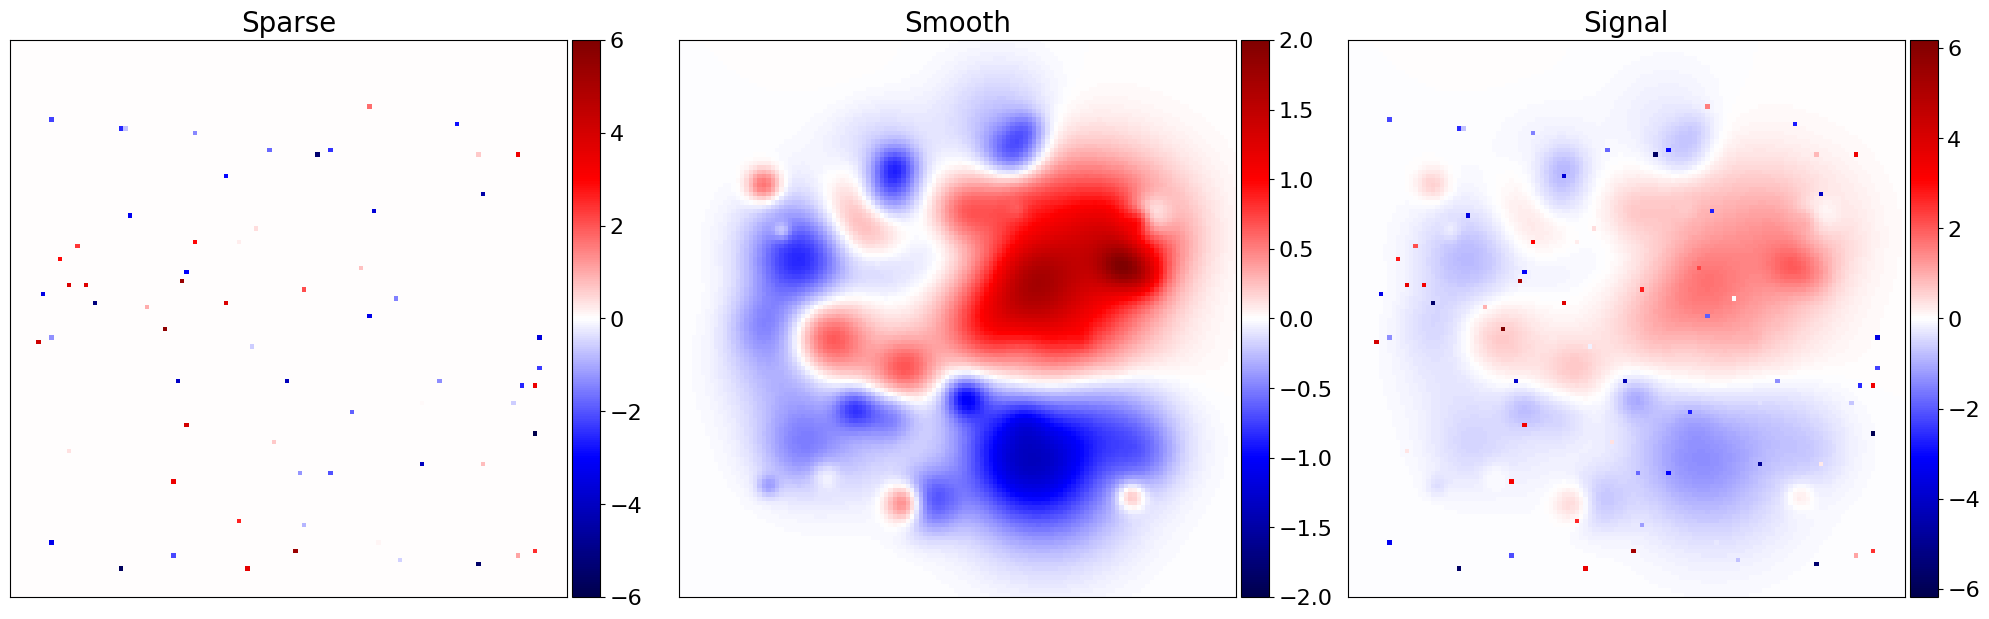

In [4]:
sparse_signal = compute_sparse(N, sparse_range, density, seed)
smooth_signal = compute_smooth(N, smooth_amplitude, sigmas_range, nb_gaussian, seed)

signal = sparse_signal + smooth_signal

plot_signal(sparse_signal, smooth_signal);

# Operator $\phi$

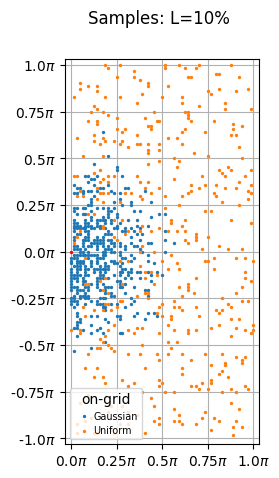

In [5]:
L = 0.1
theta = 0.5
op = NuFFT(N, L, theta, on_grid=True, seed=seed)

x0 = signal.reshape(-1)
y0 = op(x0)

psnr = 50
y = compute_y(y0, psnr)

op.plot_samples()

# Solver

In [6]:
# Loss weights
lambda1 = 1e-2
lambda2 = 5e-2

# Use Laplacian ?
laplacian = True

### Coupled

In [7]:
coupled = True

start_coupled = time.time()
(x1_coupled, x2_coupled), t_coupled = solve(y, op, lambda1, lambda2, coupled, laplacian)
total_t_coupled = time.time() - start_coupled

Coupled
INFO -- [2024-01-05 11:23:10.658115] Iteration 0
	iteration: 0
	N_iter: 1.0
	RelError[x]: 0.0
INFO -- [2024-01-05 11:23:34.673153] Iteration 500
	iteration: 500
	N_iter: 501.0
	RelError[x]: 0.0004054990541516527
INFO -- [2024-01-05 11:23:41.768159] Iteration 660
	iteration: 660
	N_iter: 661.0
	RelError[x]: 9.968020997368406e-05
INFO -- [2024-01-05 11:23:41.769246] Stopping Criterion satisfied -> END


sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x1563a63e0>


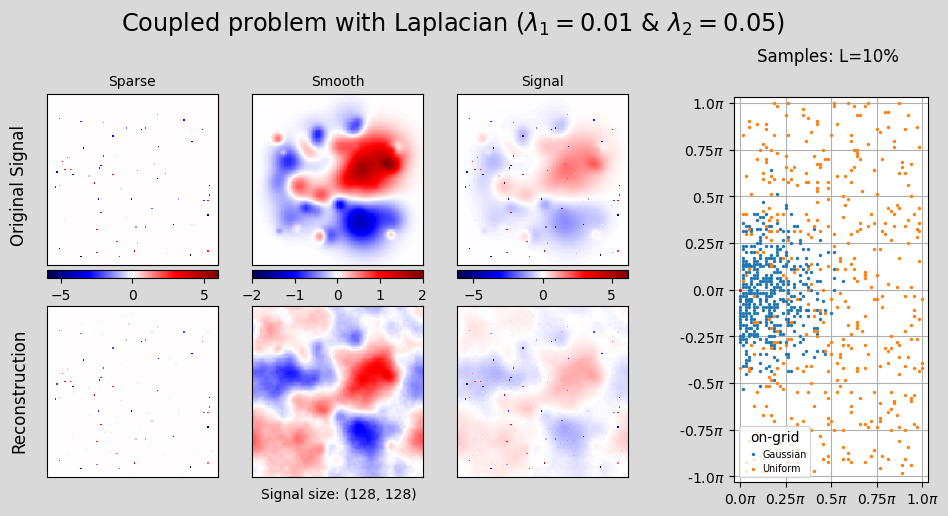

Button(description='SAVE', style=ButtonStyle())

Output()

In [8]:
sparse_rcstr_coupled, smooth_rcstr_coupled, signal_rcstr_coupled = map(
    lambda x: x.reshape((N,N)), (x1_coupled, x2_coupled, x1_coupled + x2_coupled)
)

fig = plot_results(
    [sparse_signal, smooth_signal],
    [sparse_rcstr_coupled, smooth_rcstr_coupled],
    lambda1,
    lambda2,
    op,
    coupled,
    laplacian
)

save_widget(fig, lambda1, lambda2, op, psnr, coupled)

### Decoupled

In [9]:
coupled = False

start_decoupled = time.time()
(x1_decoupled, x2_decoupled), t_decoupled = solve(y, op, lambda1, lambda2, coupled, laplacian)
total_t_decoupled = time.time() - start_decoupled

Decoupled
Co-Gram Identity
INFO -- [2024-01-05 11:23:50.166909] Iteration 0
	iteration: 0
	N_iter: 1.0
	RelError[x]: 0.0
INFO -- [2024-01-05 11:23:52.698947] Iteration 194
	iteration: 194
	N_iter: 195.0
	RelError[x]: 9.863397053792337e-05
INFO -- [2024-01-05 11:23:52.700286] Stopping Criterion satisfied -> END


sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x1574bfac0>


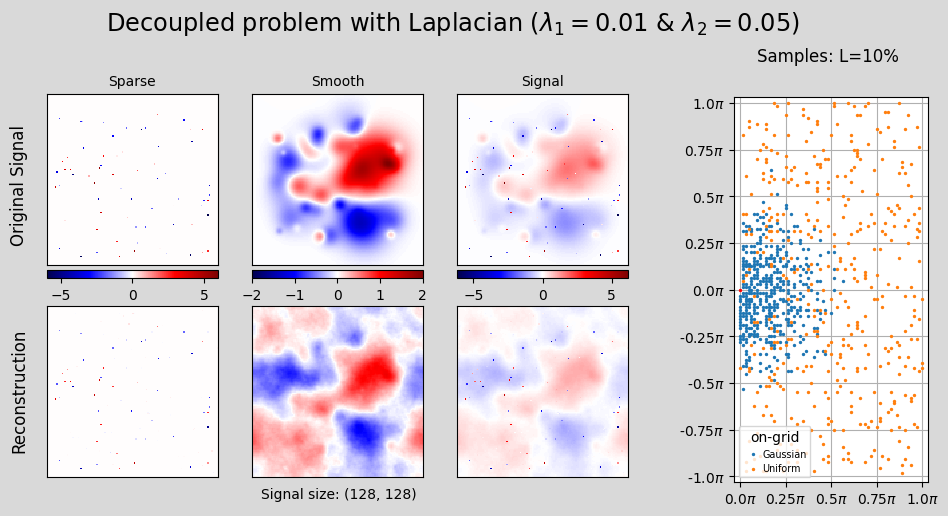

Button(description='SAVE', style=ButtonStyle())

Output()

In [10]:
sparse_rcstr_decoupled, smooth_rcstr_decoupled, signal_rcstr_decoupled = map(
    lambda x: x.reshape((N,N)), (x1_decoupled, x2_decoupled, x1_decoupled + x2_decoupled)
)

fig = plot_results(
    [sparse_signal, smooth_signal],
    [sparse_rcstr_decoupled, smooth_rcstr_decoupled],
    lambda1,
    lambda2,
    op,
    coupled,
    laplacian
)

save_widget(fig, lambda1, lambda2, op, psnr, coupled)

# Comparison

In [11]:
if laplacian : 
    laplacian_op = Laplacian((N, N), mode="wrap")

In [14]:
approaches = ["Coupled", "Decoupled"]
data_sets = [
    (sparse_rcstr_coupled, smooth_rcstr_coupled, t_coupled, total_t_coupled),
    (sparse_rcstr_decoupled, smooth_rcstr_decoupled, t_decoupled, total_t_decoupled),
]

for approach, (sparse_rcstr, smooth_rcstr, t, total_t) in zip(approaches, data_sets):
    print(f"{approach} Approach")

    data_fidelity, L2, L1, = objective_func(
        op,
        laplacian_op,
        y,
        sparse_rcstr,
        smooth_rcstr,
        lambda1,
        lambda2,
    )

    print(
        f"  Cost:  {data_fidelity+L2+L1:.0f}\n" +   
        f"    - Data fidelity: {data_fidelity:.0f}\n"+   
        f"    - L2: {L2:.0f} \n"+  
        f"    - L1: {L1:.0f}" 
    )
    print(f"  Time [s]: \n" +
        f"    - With preprocessing : {total_t :.2f}\n"+   
        f"    - Without preprocessing: {t:.2f} \n")


Coupled Approach
  Cost:  19806
    - Data fidelity: 1645
    - L2: 2684 
    - L1: 15478
  Time [s]: 
    - With preprocessing : 43.20
    - Without preprocessing: 31.12 

Decoupled Approach
  Cost:  21633
    - Data fidelity: 4689
    - L2: 5497 
    - L1: 11446
  Time [s]: 
    - With preprocessing : 9.50
    - Without preprocessing: 2.56 



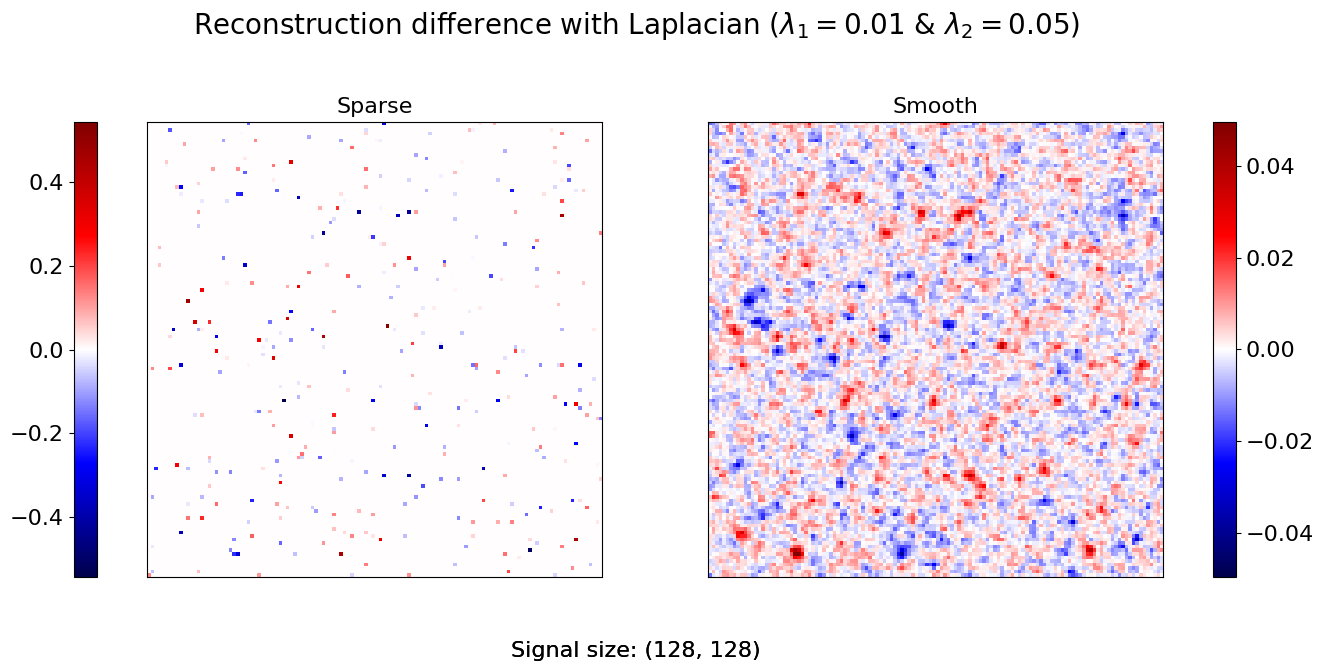

In [13]:
difference(N,
    laplacian,
    lambda1,
    lambda2,
    sparse_rcstr_coupled,
    sparse_rcstr_decoupled,
    smooth_rcstr_coupled,
    smooth_rcstr_decoupled);

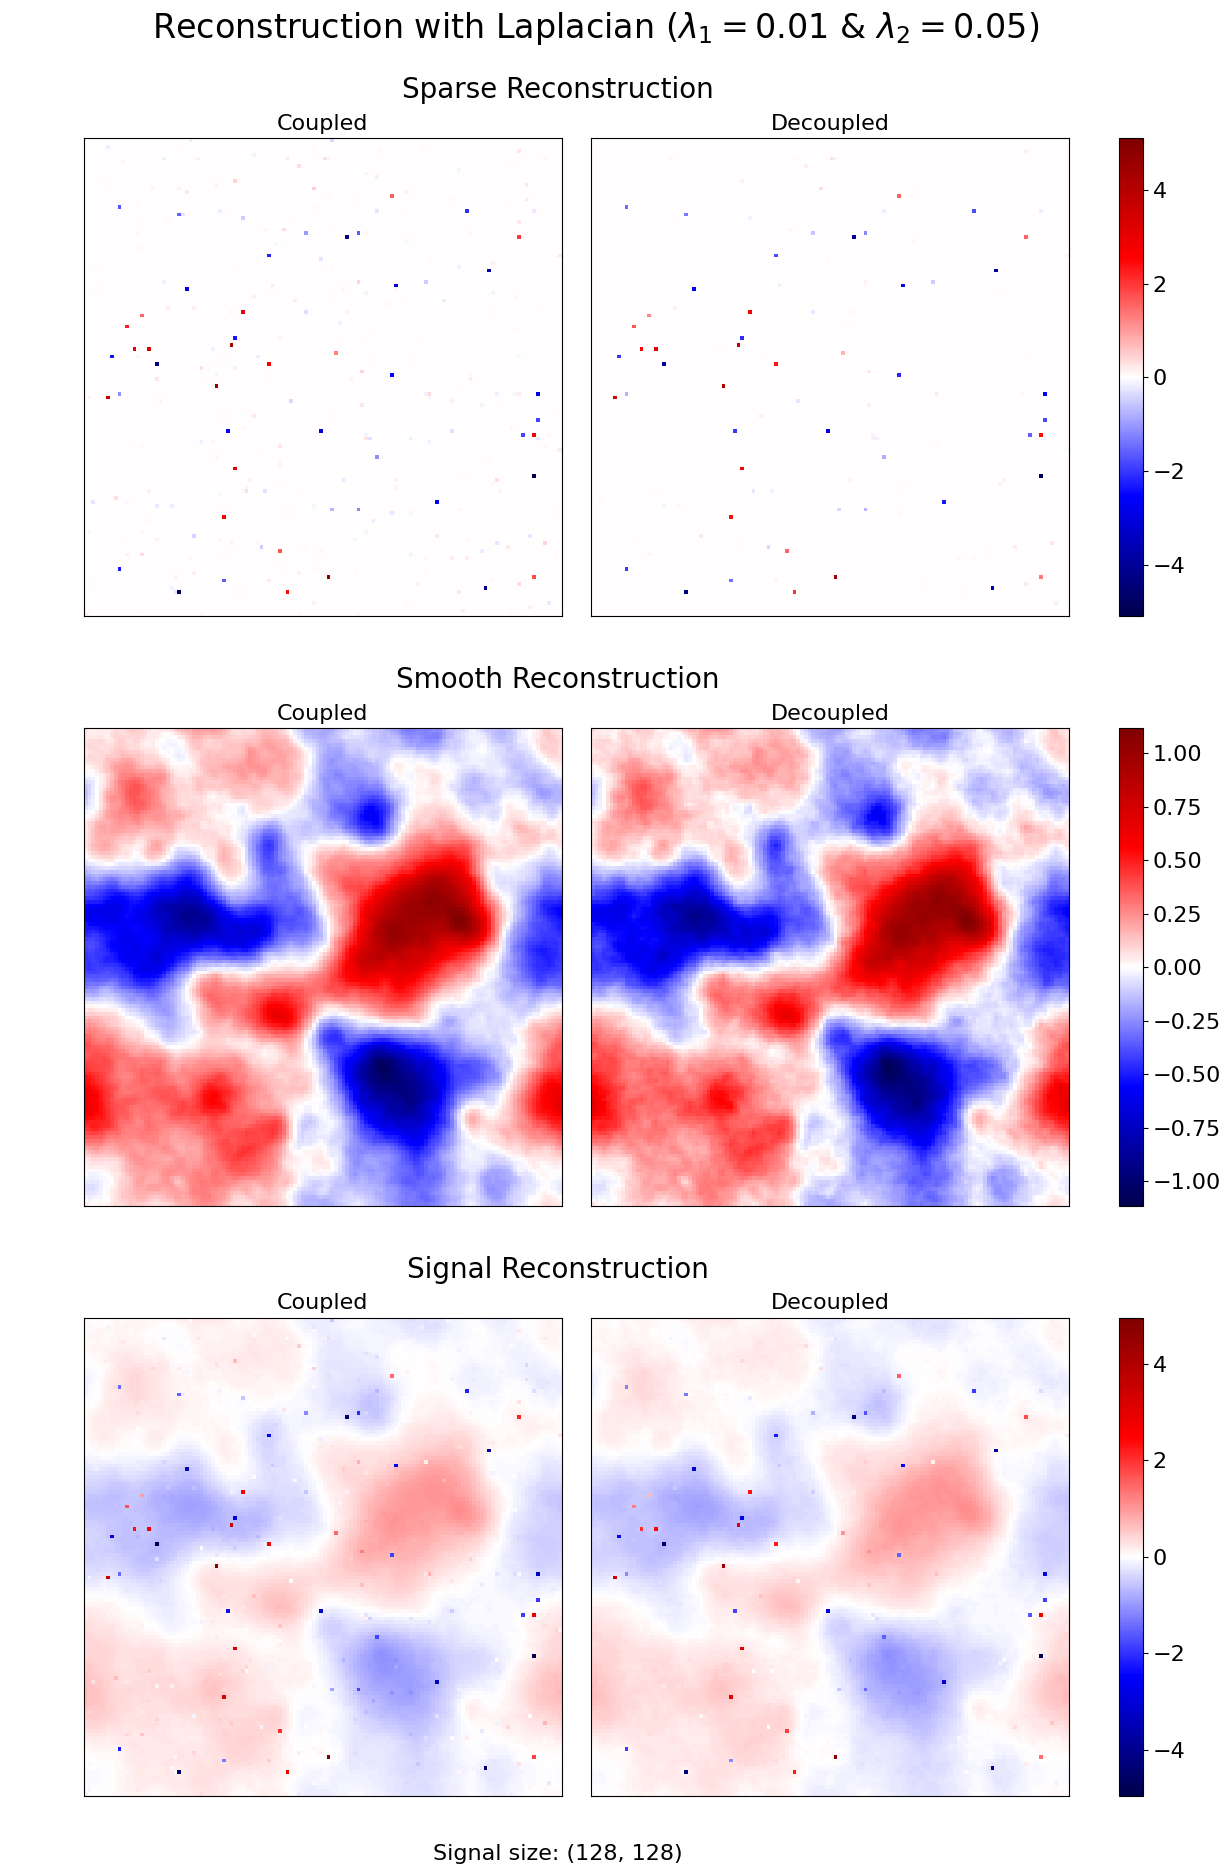

In [17]:
compare(
    N,
    laplacian,
    lambda1,
    lambda2,
    sparse_rcstr_coupled,
    sparse_rcstr_decoupled,
    smooth_rcstr_coupled,
    smooth_rcstr_decoupled,
    signal_rcstr_coupled,
    signal_rcstr_decoupled,
);

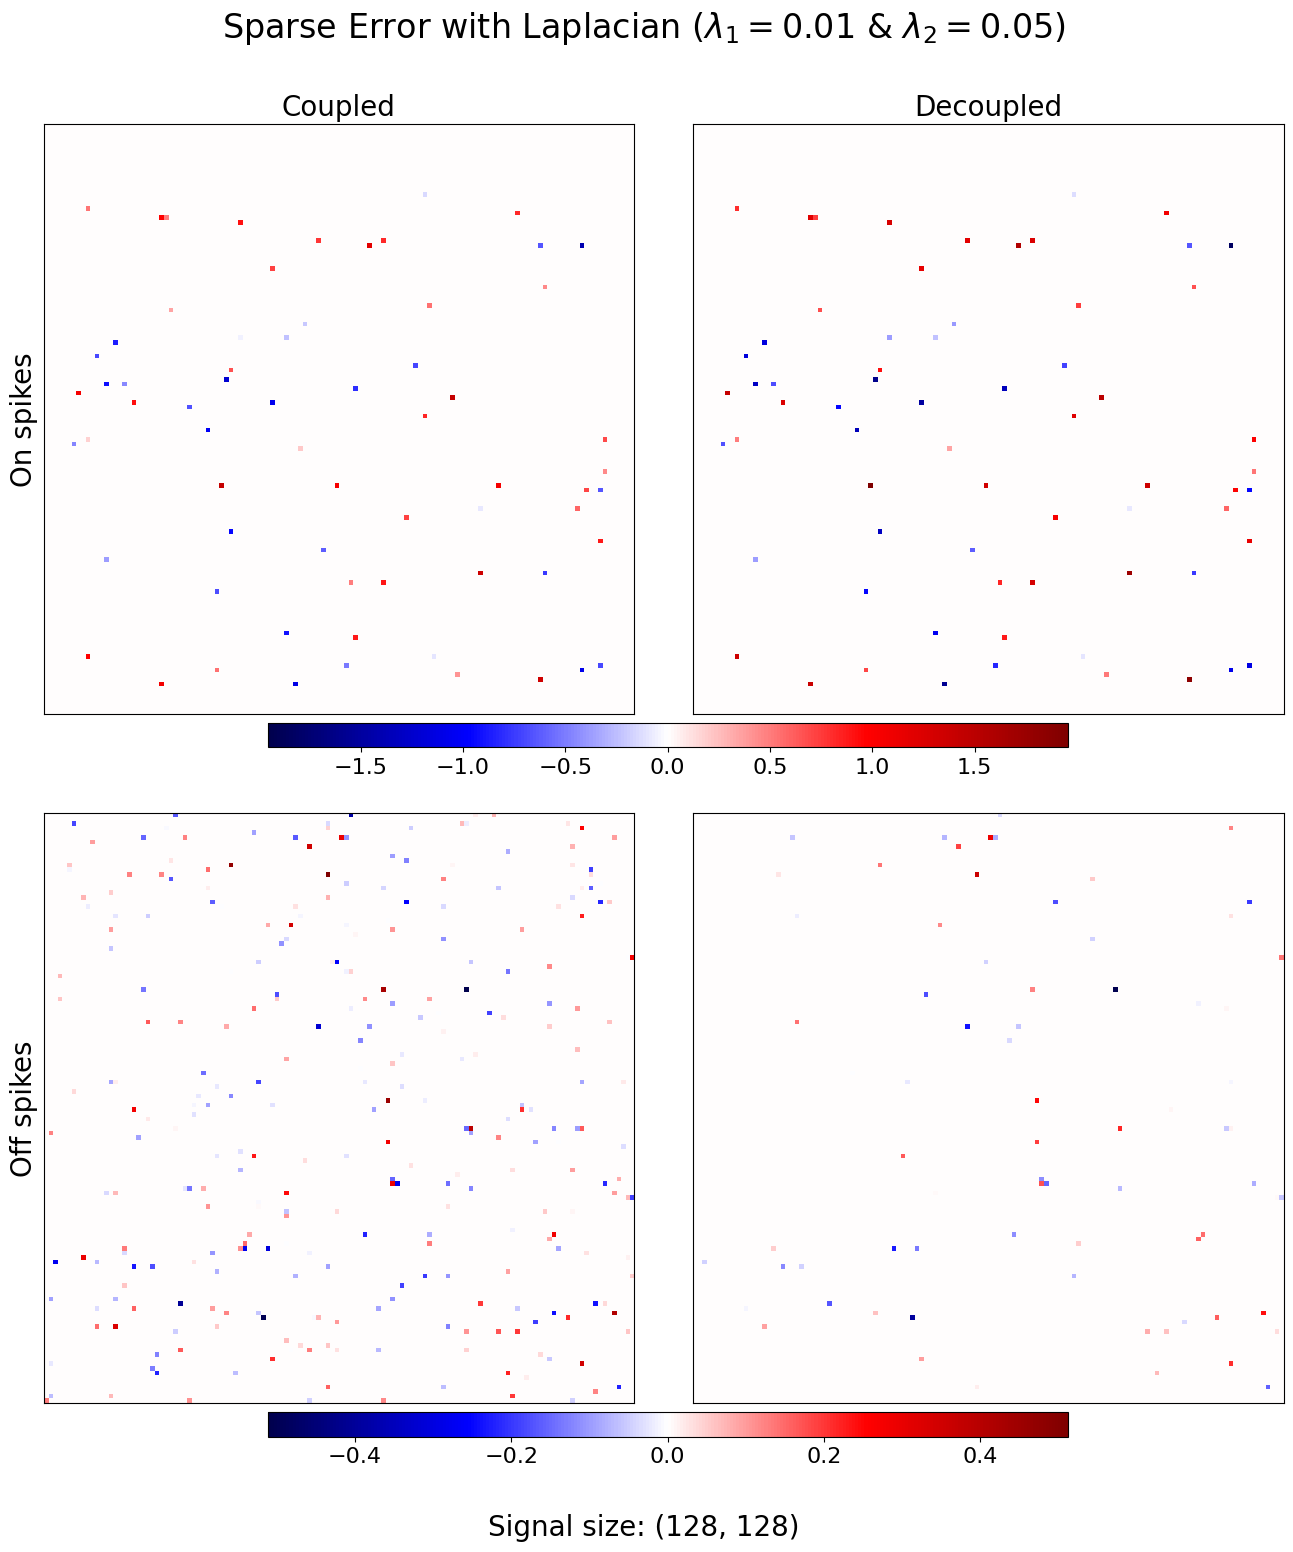

In [19]:
sparse_error(
    N,
    laplacian,
    lambda1,
    lambda2,
    sparse_signal,
    sparse_rcstr_coupled,
    sparse_rcstr_decoupled,
);